# Bagel Factor Example Notebook

This notebook demonstrates a typical factor evaluation workflow using Bagel Factor:
- Load price and factor data
- Prepare aligned future returns
- Build `FactorData` containers (optional but handy)
- Compute IC/ICIR and quantile returns
- Visualize the results

Prerequisites:
- Installed package: `pip install bagel-factor` (or local editable install)
- Input CSVs under `tests/test_data` (provided in repo)

Tip for large datasets:
- Use `FactorData.unsafe_from_series(...)` when your data is already validated/sorted.
- Ensure factor and returns indices match exactly to trigger Evaluator's fast path.


# Example for bagel-factor package

Steps:

1. Prepare data
2. Evaluator object and its methods
3. Visualization

---

## 0. Loading the package

In [1]:
from bagel_factor import FactorData  # DataFrame wrapper to ensure correct data types
from bagel_factor import cross_sectional_zscore  # Preprocessing function
from bagel_factor import Evaluator  # Evaluator class for factor analysis
from bagel_factor import plot_ic_series, plot_quantile_returns, plot_cumulative_spread

## Data loading

We use sample CSVs from `tests/test_data`:
- `price.csv`: adjusted close prices (date, ticker)
- `roe.csv`: example factor (return on equity) (date, ticker)

Below, we load both, drop duplicates, and sort. We then create future returns (20D ahead) and forward-fill factor values per ticker to avoid look-ahead bias.

In [2]:
import pandas as pd
factor = pd.read_csv(
            'tests/test_data/roe.csv',
            parse_dates=['date'],
            index_col=['date', 'ticker']
)['roe'].sort_index()
    
price = pd.read_csv(
    'tests/test_data/price.csv',
    usecols=['date', 'ticker', 'adj_close'],
    parse_dates=['date'],
    index_col=['date', 'ticker']
)['adj_close'].sort_index()
# Drop duplicate indices
price = price[~price.index.duplicated(keep='first')]
factor = factor[~factor.index.duplicated(keep='first')]

In [3]:
factor_data = FactorData(factor, factor_name='roe', validate=True, enforce_sorted=False)
price_data = FactorData(price, factor_name='price', validate=True, enforce_sorted=False)


print(f'Factor data: {factor_data}')
print(f'Future returns: {price_data}')

Factor data: FactorData(name=roe, size=72571)
Future returns: FactorData(name=price, size=4905643)


## FactorData containers (optional, ergonomic)

`FactorData` provides a validated container with metadata and utilities. For high throughput:
- Use `validate=False, enforce_sorted=False` when the schema/order is already correct.
- Or use `FactorData.unsafe_from_series(...)` for a trusted fast path.

In [4]:
factor_data_z = factor_data.standardize(method=cross_sectional_zscore)

## Evaluator

The `Evaluator` orchestrates IC, quantile returns, and risk metrics. It will skip alignment work when `factor_data.factor_data.index` equals the returns index.

Set an evaluation window if needed using `set_start_date`/`set_end_date`.

In [5]:
evaluator = Evaluator(
    factor_data=factor_data_z,
    price_data=price_data,
    factor_name='roe'
)
evaluator.set_ic_horizon(126)
evaluator.set_rebalance_period(21)

## Information Coefficient (IC)

IC measures cross-sectional correlation between factor values and future returns per date.
- Pearson IC: linear relationship
- Spearman IC: rank correlation (robust to monotonic transforms)

We compute and plot the IC time series. The dashed red line indicates the mean IC.

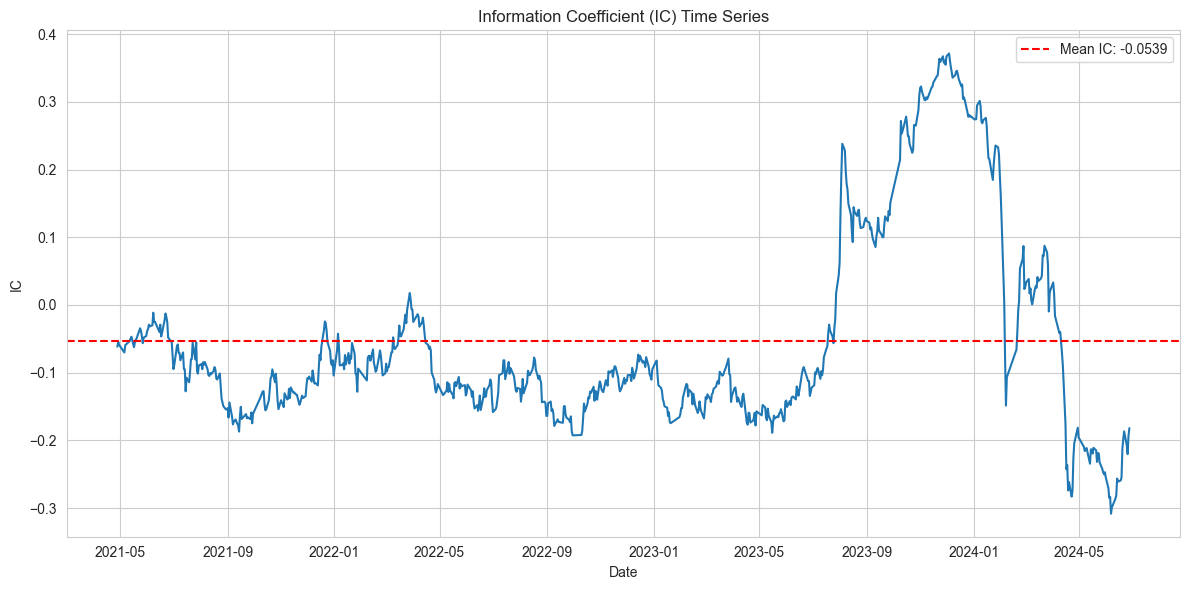

In [7]:
ic_series = evaluator.ic_series(method='spearman')
ic_fig = plot_ic_series(ic_series)

## Quantile Analysis

Quantile returns and other statistics can be computed using the `Evaluator` class.

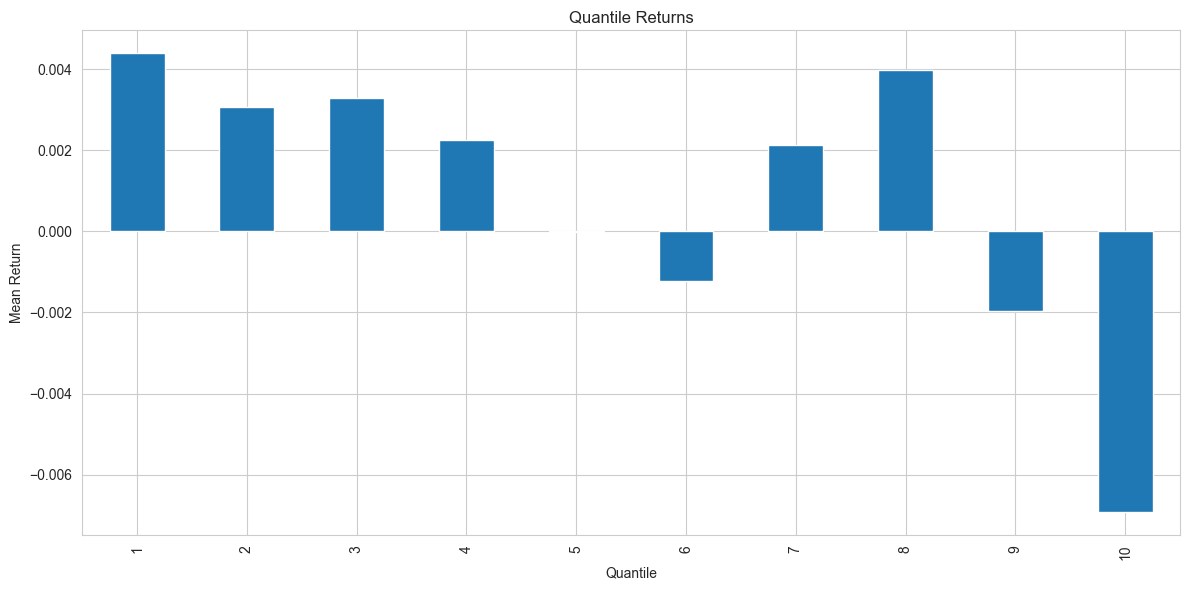

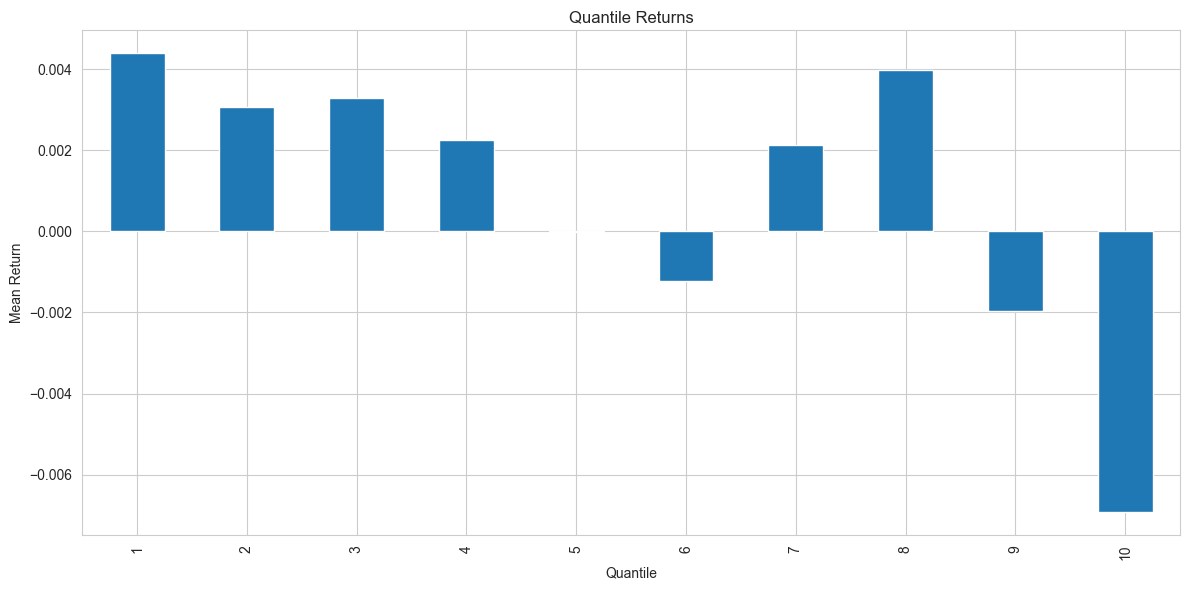

In [ ]:
quantile_returns_df = evaluator.quantile_return_df()
fig = plot_quantile_returns(quantile_returns_df)

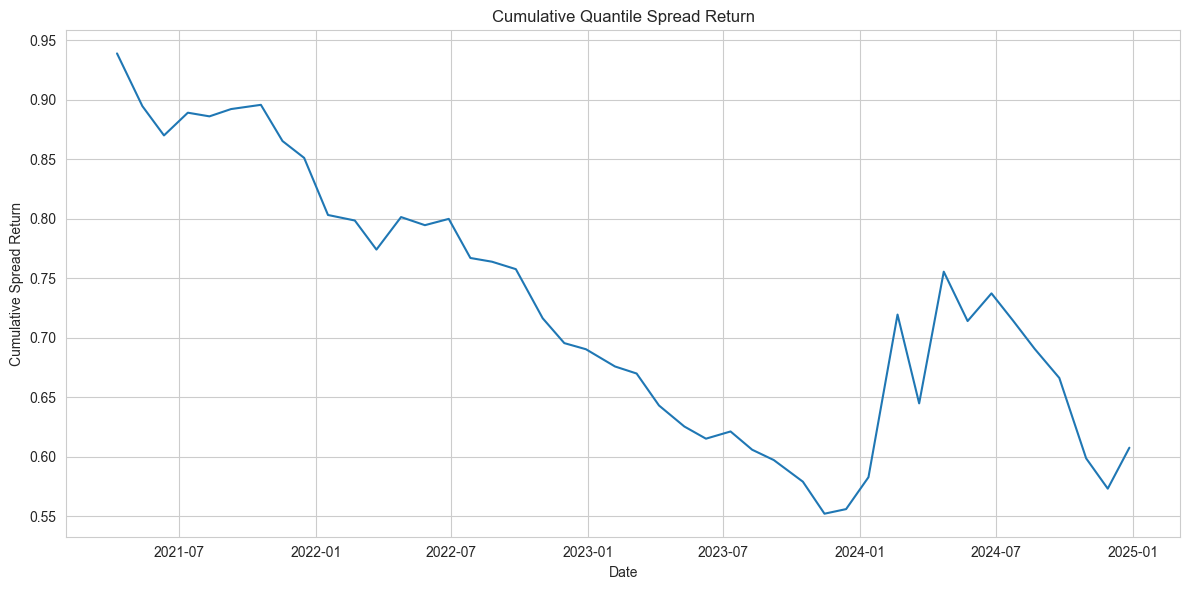

In [9]:
quantile_spread = evaluator.quantile_spread_series()
fig = plot_cumulative_spread(quantile_spread)